In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal,permutation
import pandas as pd
from pandas import DataFrame,Series

In [4]:
#시드를 명시적으로 지정하면 매번 동일한 데이터가 생성되기 때문에
#난수를 이용하더라도 동일한 데이터로 반복 테스트 할 수 있다.
np.random.seed(20160512)

In [5]:
# n0는 갯수, mu0는 평균, variance0 은 편차를 의미
# t항목같은 경우 감염인지 비감염인지를 판정해주는 항목
n0,mu0,variance0 = 20,[10,11],20
data0 = multivariate_normal(mu0,np.eye(2)*variance0,n0)
df0 = DataFrame(data0,columns=['x1','x2'])
df0['t'] = 0

In [6]:
n1,mu1,variance1 = 15,[18,20],22
data1 = multivariate_normal(mu1,np.eye(2)*variance1,n1)
df1 = DataFrame(data1,columns=['x1','x2'])
df1['t'] = 1

# ignore_index같은 경우 두 데이터를 합쳤을 때 index가 0부터 연속하도록 한다.
df = pd.concat([df0,df1],ignore_index=True)

In [7]:
#학습을 위해 무작위로 순번을 변경하자
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [8]:
#(x1,x2)와 t를 각각 모은것을 Numpy의 array 오브젝트로 추출하자
train_x = train_set[['x1','x2']].values
# train_t의 경우 그냥 array오브젝트로 추출하면 1차원 배열(1*n)이 되게때문에
# reshape를 통해 n*1 형의 모양으로 바꿔준다
train_t = train_set['t'].values.reshape(([len(train_set),1]))

In [9]:
x = tf.placeholder(tf.float32,[None,2])
w = tf.Variable(tf.zeros([2,1]))
w0 = tf.Variable(tf.zeros([1]))
f = tf.matmul(x,w) + w0
p = tf.sigmoid(f)

In [10]:
# binary cross entropy를 통해서 loss를 추출해내는 모습
t = tf.placeholder(tf.float32,[None,1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.AdamOptimizer().minimize(loss)

In [11]:
#추가적으로 정답률을 나타내는 계산식을 세워보자
#여기서 나타나는 tf.sign은 값이 0 미안 , 0 , 0 초과 인 경우에 따라 값을 주는 함수이다
#tf.reduce_mean 은 전체적인 평균을 구하는 식이다.
#tf.cast 는 텐서를 새로운 형태로 캐스팅하는데 사용한다.
correct_prediction = tf.equal(tf.sign(p-0.5),tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
i = 0
for _ in range(20000):
    i += 1
    sess.run(train_step, feed_dict = {x:train_x, t:train_t})
    if i % 2000 == 0:
        loss_val, acc_val = sess.run([loss,accuracy],feed_dict={x:train_x,t:train_t})
        print('Step: %d, Loss: %f, Accuracy: %f' %(i,loss_val,acc_val))

Step: 2000, Loss: 3.534095, Accuracy: 0.942857
Step: 4000, Loss: 3.483960, Accuracy: 0.942857
Step: 6000, Loss: 3.460642, Accuracy: 0.942857
Step: 8000, Loss: 3.453656, Accuracy: 0.942857
Step: 10000, Loss: 3.452987, Accuracy: 0.942857
Step: 12000, Loss: 3.452984, Accuracy: 0.942857
Step: 14000, Loss: 3.452986, Accuracy: 0.942857
Step: 16000, Loss: 3.452984, Accuracy: 0.942857
Step: 18000, Loss: 3.452984, Accuracy: 0.942857
Step: 20000, Loss: 3.452983, Accuracy: 0.942857


In [21]:
w0_val, w_val = sess.run([w0,w])
w0_val, w1_val, w2_val = w0_val[0],w_val[0][0],w_val[1][0]
print(w0_val,w1_val,w2_val)

-21.151854 0.7571539 0.66940254


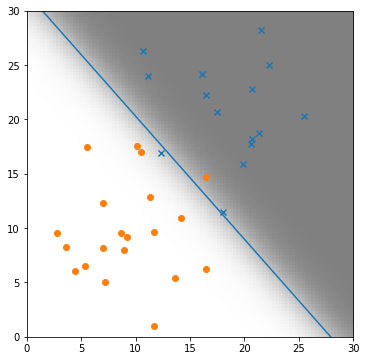

In [24]:
train_set0 = train_set[train_set['t']==0]
train_set1 = train_set[train_set['t']==1]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1,train_set1.x2,marker='x')
subplot.scatter(train_set0.x1,train_set0.x2,marker='o')

linex = np.linspace(0,30,10)
liney = -(w1_val*linex/w2_val + w0_val/w2_val)
subplot.plot(linex,liney)

field = [[(1 / (1 + np.exp(-(w0_val + w1_val*x1 + w2_val*x2))))
          for x1 in np.linspace(0,30,100)]
         for x2 in np.linspace(0,30,100)]
subplot.imshow(field, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)